## Notes
- If GPU is available, the notebook will use CUDA automatically.
- Tumor predictions are optionally restricted to the predicted liver region.
- Adjust thresholds or post-processing as needed for your data.

In [1]:
# Kernel diagnostics
import sys, torch
print('sys.executable:', sys.executable)
print('torch file:', torch.__file__)
print('torch version:', torch.__version__)
print('torch.version.cuda:', torch.version.cuda)
print('cuda available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

sys.executable: c:\Users\User\Documents\LiTS\.venv\Scripts\python.exe
torch file: c:\Users\User\Documents\LiTS\.venv\Lib\site-packages\torch\__init__.py
torch version: 2.5.1+cu121
torch.version.cuda: 12.1
cuda available: True
GPU: NVIDIA GeForce RTX 3070


## Prerequisites
- Select the Jupyter kernel: `Python 3.11 (.venv LiTS)`.
- Ensure the checkpoints exist in `models/liver_checkpoint.pt` and `models/tumor_checkpoint.pt`.
- Place new volumes in `Test_Volume` (files: `.nii` or `.nii.gz`).

In [2]:
# Imports and device setup
import os, glob, numpy as np, nibabel as nib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Python Torch:', torch.__version__)
print('Using device:', device, '| CUDA available:', torch.cuda.is_available())

Python Torch: 2.5.1+cu121
Using device: cuda | CUDA available: True


In [3]:
# Dense U-Net definition (must match training architecture)
class DenseLayer(nn.Module):
    def __init__(self, in_ch, growth_rate):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_ch, growth_rate, kernel_size=3, padding=1, bias=False)
    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], dim=1)

class DenseBlock(nn.Module):
    def __init__(self, in_ch, growth_rate, n_layers):
        super().__init__()
        layers = []
        ch = in_ch
        for _ in range(n_layers):
            layers.append(DenseLayer(ch, growth_rate))
            ch += growth_rate
        self.net = nn.Sequential(*layers)
        self.out_ch = ch
    def forward(self, x):
        return self.net(x)

class TransitionDown(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        return self.pool(self.conv(x))

class TransitionUp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
    def forward(self, x):
        return self.up(x)

class DenseUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, growth_rate=8, layers_per_block=[2,2,2,2]):
        super().__init__()
        self.init_conv = nn.Conv2d(in_channels, growth_rate*2, kernel_size=3, padding=1, bias=False)
        ch = growth_rate*2
        self.down_blocks = nn.ModuleList()
        self.trans_downs = nn.ModuleList()
        self.skip_channels = []
        for l in layers_per_block:
            db = DenseBlock(ch, growth_rate, l)
            self.down_blocks.append(db)
            ch = db.out_ch
            self.skip_channels.append(ch)
            td = TransitionDown(ch, ch)
            self.trans_downs.append(td)
        self.bottleneck = DenseBlock(ch, growth_rate, 12)
        prev_ch = self.bottleneck.out_ch
        self.trans_up = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        for l, skip_ch in zip(reversed(layers_per_block), reversed(self.skip_channels)):
            tu = TransitionUp(prev_ch, prev_ch // 2)
            self.trans_up.append(tu)
            tu_out_ch = prev_ch // 2
            db_in_ch = tu_out_ch + skip_ch
            db = DenseBlock(db_in_ch, growth_rate, l)
            self.up_blocks.append(db)
            prev_ch = db.out_ch
        self.final_conv = nn.Conv2d(prev_ch, out_channels, kernel_size=1)
    def forward(self, x):
        x = self.init_conv(x)
        skips = []
        for db, td in zip(self.down_blocks, self.trans_downs):
            x = db(x)
            skips.append(x)
            x = td(x)
        x = self.bottleneck(x)
        for tu, ub, skip in zip(self.trans_up, self.up_blocks, reversed(skips)):
            x = tu(x)
            if x.shape != skip.shape:
                _, _, H, W = x.shape
                skip = skip[:, :, :H, :W]
            x = torch.cat([x, skip], dim=1)
            x = ub(x)
        x = self.final_conv(x)
        return x

In [4]:
# Load models from checkpoints
def load_model_from_checkpoint(checkpoint_path, device):
    ckpt = torch.load(checkpoint_path, map_location=device)
    cfg = ckpt['config']['model_params']
    model = DenseUNet(**cfg).to(device)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()
    return model

liver_ckpt = os.path.join('models', 'liver_checkpoint.pt')
tumor_ckpt = os.path.join('models', 'tumor_checkpoint.pt')

liver_model = load_model_from_checkpoint(liver_ckpt, device) if os.path.exists(liver_ckpt) else None
tumor_model = load_model_from_checkpoint(tumor_ckpt, device) if os.path.exists(tumor_ckpt) else None

print('Liver model loaded:', liver_model is not None)
print('Tumor model loaded:', tumor_model is not None)

C:\Users\User\AppData\Local\Temp\ipykernel_30648\3476034283.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


Liver model loaded: True
Tumor model loaded: True


In [5]:
# Inference utilities
def normalize_volume(vol):
    vol = vol.astype(np.float32)
    return (vol - vol.min()) / (vol.max() - vol.min() + 1e-8)

def predict_mask_3d(model, vol, device, threshold=0.5):
    vol_n = normalize_volume(vol)
    H, W, Z = vol_n.shape
    out = np.zeros((H, W, Z), dtype=np.float32)
    with torch.no_grad():
        for z in range(Z):
            img = vol_n[:, :, z]
            x = torch.from_numpy(img[np.newaxis, np.newaxis, :, :]).to(device).float()
            logits = model(x)
            pred = torch.sigmoid(logits).cpu().numpy()[0,0]
            out[:, :, z] = (pred >= threshold).astype(np.float32)
    return out

def save_nifti(mask, reference_nii, out_path):
    ref = nib.load(reference_nii)
    img = nib.Nifti1Image(mask.astype(np.uint8), ref.affine, ref.header)
    nib.save(img, out_path)

# Inference

In [6]:
# Scan new volumes and save predictions
in_dir = 'Test_Volume'
out_root = 'eval_outputs'
out_liver = os.path.join(out_root, 'liver')
out_tumor = os.path.join(out_root, 'tumor')
os.makedirs(out_liver, exist_ok=True)
os.makedirs(out_tumor, exist_ok=True)

vol_paths = sorted(glob.glob(os.path.join(in_dir, '*.nii*')))
print('Found volumes:', len(vol_paths))

for vp in vol_paths:
    print('Processing:', os.path.basename(vp))
    vol = nib.load(vp).get_fdata().astype(np.float32)
    # Liver prediction
    if liver_model is not None:
        liver_mask = predict_mask_3d(liver_model, vol, device, threshold=0.5)
        liver_out = os.path.join(out_liver, 'liver_pred_' + os.path.basename(vp).replace('.nii.gz', '.nii').replace('.nii', '.nii'))
        save_nifti(liver_mask, vp, liver_out)
    else:
        print('Skipped liver: model not loaded')
    # Tumor prediction (optionally restrict to liver region)
    if tumor_model is not None:
        tumor_mask = predict_mask_3d(tumor_model, vol, device, threshold=0.5)
        if liver_model is not None:
            # Restrict tumor predictions to predicted liver area
            tumor_mask = tumor_mask * (liver_mask > 0)
        tumor_out = os.path.join(out_tumor, 'tumor_pred_' + os.path.basename(vp).replace('.nii.gz', '.nii').replace('.nii', '.nii'))
        save_nifti(tumor_mask, vp, tumor_out)
    else:
        print('Skipped tumor: model not loaded')

print('Inference complete. Outputs saved to:', out_root)

Found volumes: 4
Processing: test-volume-0.nii
Processing: test-volume-1.nii
Processing: test-volume-2.nii
Processing: test-volume-3.nii
Inference complete. Outputs saved to: eval_outputs


## First test volume

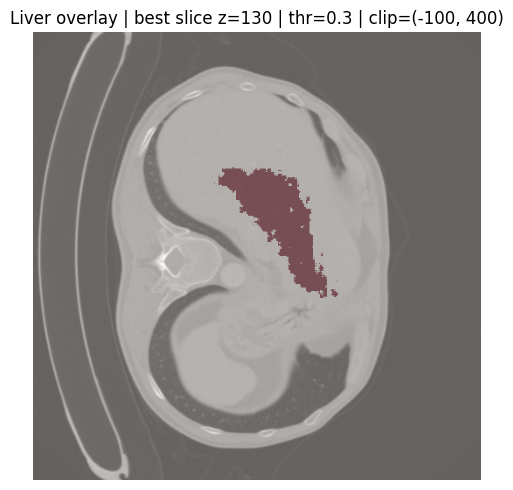

Volume: test-volume-0.nii | Liver voxels: 44364
Note: This view shows the slice with maximum predicted liver area.


In [7]:
# Find best slice for liver and try fallback preprocessing
# Purpose: If mid-slice shows nothing, this finds the slice with
# the largest predicted liver area and retries with lower threshold
# and optional CT windowing if needed.

import numpy as np
import matplotlib.pyplot as plt

# Helper: prediction with optional HU clip and custom threshold
def predict_mask_3d_with_clip(model, vol, device, threshold=0.5, clip=None):
    v = vol.astype(np.float32)
    if clip is not None:
        v = np.clip(v, clip[0], clip[1])
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)
    H, W, Z = v.shape
    out = np.zeros((H, W, Z), dtype=np.float32)
    with torch.no_grad():
        for z in range(Z):
            img = v[:, :, z]
            x = torch.from_numpy(img[np.newaxis, np.newaxis, :, :]).to(device).float()
            logits = liver_model(x)
            pred = torch.sigmoid(logits).cpu().numpy()[0, 0]
            out[:, :, z] = (pred >= threshold).astype(np.float32)
    return out
 
# Ensure inputs
if 'vol_paths' not in globals() or len(vol_paths) == 0:
    in_dir = 'Test_Volume'
    vol_paths = sorted(glob.glob(os.path.join(in_dir, '*.nii*')))

if len(vol_paths) > 0 and liver_model is not None:
    vp = vol_paths[0]
    vol = nib.load(vp).get_fdata().astype(np.float32)

    # First try: default threshold 0.5 (matches earlier cells)
    liver_mask_base = predict_mask_3d(liver_model, vol, device, threshold=0.5)
    vox_base = int(liver_mask_base.sum())

    # Fallback try: lower threshold + soft tissue HU clip [-100, 400]
    liver_mask_fallback = predict_mask_3d_with_clip(liver_model, vol, device, threshold=0.3, clip=(-100, 400))
    vox_fb = int(liver_mask_fallback.sum())

    # Pick the one with more voxels
    if vox_fb > vox_base:
        liver_mask = liver_mask_fallback
        used_threshold = 0.3
        used_clip = (-100, 400)
    else:
        liver_mask = liver_mask_base
        used_threshold = 0.5
        used_clip = None

    # If still empty, try just lower threshold without clipping
    if int(liver_mask.sum()) == 0:
        liver_mask_lo = predict_mask_3d_with_clip(liver_model, vol, device, threshold=0.3, clip=None)
        if int(liver_mask_lo.sum()) > 0:
            liver_mask = liver_mask_lo
            used_threshold = 0.3
            used_clip = None

    total_vox = int(liver_mask.sum())

    if total_vox == 0:
        print('No liver voxels detected. Likely threshold/preprocessing mismatch.')
        print('Suggestions: lower threshold, ensure HU windowing, or apply largest component post-processing.')
    else:
        # Find slice with maximum liver area
        per_slice = liver_mask.sum(axis=(0, 1))
        z_best = int(np.argmax(per_slice))
        img = vol[:, :, z_best]
        img_n = (img - img.min()) / (img.max() - img.min() + 1e-8)

        plt.figure(figsize=(6, 5))
        plt.imshow(img_n, cmap='gray')
        plt.imshow(liver_mask[:, :, z_best], cmap='Reds', alpha=0.4)
        ttl = f'Liver overlay | best slice z={z_best} | thr={used_threshold}'
        if used_clip is not None:
            ttl += f' | clip={used_clip}'
        plt.title(ttl)
        plt.axis('off')
        plt.tight_layout(); plt.show()

        print(f'Volume: {os.path.basename(vp)} | Liver voxels: {total_vox}')
        print('Note: This view shows the slice with maximum predicted liver area.')
else:
    print('No volumes or liver model unavailable.')

## Second test volume

In [8]:
# Second test volume - same liver analysis as first test volume
# Purpose: If mid-slice shows nothing, this finds the slice with
# the largest predicted liver area and retries with lower threshold
# and optional CT windowing if needed.

import numpy as np
import matplotlib.pyplot as plt

# Helper: prediction with optional HU clip and custom threshold
# (copied from the first test volume cell)
def predict_mask_3d_with_clip(model, vol, device, threshold=0.5, clip=None):
    v = vol.astype(np.float32)
    if clip is not None:
        v = np.clip(v, clip[0], clip[1])
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)
    H, W, Z = v.shape
    out = np.zeros((H, W, Z), dtype=np.float32)
    with torch.no_grad():
        for z in range(Z):
            img = v[:, :, z]
            x = torch.from_numpy(img[np.newaxis, np.newaxis, :, :]).to(device).float()
            logits = liver_model(x)
            pred = torch.sigmoid(logits).cpu().numpy()[0, 0]
            out[:, :, z] = (pred >= threshold).astype(np.float32)
    return out

# Ensure inputs
if 'vol_paths' not in globals() or len(vol_paths) == 0:
    in_dir = 'Test_Volume'
    vol_paths = sorted(glob.glob(os.path.join(in_dir, '*.nii*')))

if len(vol_paths) > 1 and liver_model is not None:
    vp = vol_paths[1]
    vol = nib.load(vp).get_fdata().astype(np.float32)

    # First try: default threshold 0.5 (matches earlier cells)
    liver_mask_base = predict_mask_3d(liver_model, vol, device, threshold=0.5)
    vox_base = int(liver_mask_base.sum())

    # Fallback try: lower threshold + soft tissue HU clip [-100, 400]
    liver_mask_fallback = predict_mask_3d_with_clip(liver_model, vol, device, threshold=0.3, clip=(-100, 400))
    vox_fb = int(liver_mask_fallback.sum())

    # Pick the one with more voxels
    if vox_fb > vox_base:
        liver_mask = liver_mask_fallback
        used_threshold = 0.3
        used_clip = (-100, 400)
    else:
        liver_mask = liver_mask_base
        used_threshold = 0.5
        used_clip = None

    # If still empty, try just lower threshold without clipping
    if int(liver_mask.sum()) == 0:
        liver_mask_lo = predict_mask_3d_with_clip(liver_model, vol, device, threshold=0.3, clip=None)
        if int(liver_mask_lo.sum()) > 0:
            liver_mask = liver_mask_lo
            used_threshold = 0.3
            used_clip = None

    total_vox = int(liver_mask.sum())

    if total_vox == 0:
        print('No liver voxels detected. Likely threshold/preprocessing mismatch.')
        print('Suggestions: lower threshold, ensure HU windowing, or apply largest component post-processing.')
    else:
        # Find slice with maximum liver area
        per_slice = liver_mask.sum(axis=(0, 1))
        z_best = int(np.argmax(per_slice))
        img = vol[:, :, z_best]
        img_n = (img - img.min()) / (img.max() - img.min() + 1e-8)

        plt.figure(figsize=(6, 5))
        plt.imshow(img_n, cmap='gray')
        plt.imshow(liver_mask[:, :, z_best], cmap='Reds', alpha=0.4)
        ttl = f'Liver overlay | best slice z={z_best} | thr={used_threshold}'
        if used_clip is not None:
            ttl += f' | clip={used_clip}'
        plt.title(ttl)
        plt.axis('off')
        plt.tight_layout(); plt.show()

        print(f'Volume: {os.path.basename(vp)} | Liver voxels: {total_vox}')
        print('Note: This view shows the slice with maximum predicted liver area.')
else:
    print('No second volume or liver model unavailable.')

No liver voxels detected. Likely threshold/preprocessing mismatch.
Suggestions: lower threshold, ensure HU windowing, or apply largest component post-processing.


## Third test volume

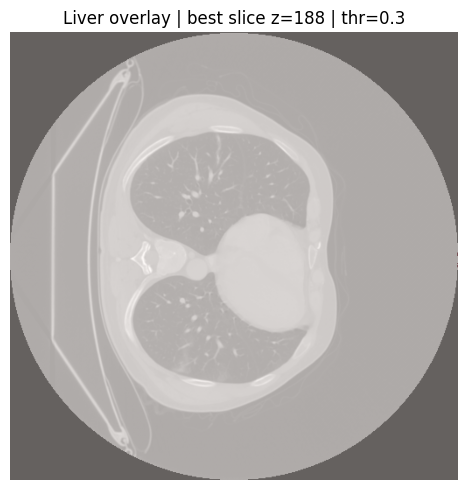

Volume: test-volume-2.nii | Liver voxels: 1532
Note: This view shows the slice with maximum predicted liver area.


In [9]:
# Third test volume - same liver analysis as first test volume
# Purpose: If mid-slice shows nothing, this finds the slice with
# the largest predicted liver area and retries with lower threshold
# and optional CT windowing if needed.

import numpy as np
import matplotlib.pyplot as plt

# Helper: prediction with optional HU clip and custom threshold
# (copied from the first test volume cell)
def predict_mask_3d_with_clip(model, vol, device, threshold=0.7, clip=None):
    v = vol.astype(np.float32)
    if clip is not None:
        v = np.clip(v, clip[0], clip[1])
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)
    H, W, Z = v.shape
    out = np.zeros((H, W, Z), dtype=np.float32)
    with torch.no_grad():
        for z in range(Z):
            img = v[:, :, z]
            x = torch.from_numpy(img[np.newaxis, np.newaxis, :, :]).to(device).float()
            logits = liver_model(x)
            pred = torch.sigmoid(logits).cpu().numpy()[0, 0]
            out[:, :, z] = (pred >= threshold).astype(np.float32)
    return out

# Ensure inputs
if 'vol_paths' not in globals() or len(vol_paths) == 0:
    in_dir = 'Test_Volume'
    vol_paths = sorted(glob.glob(os.path.join(in_dir, '*.nii*')))

if len(vol_paths) > 2 and liver_model is not None:
    vp = vol_paths[2]
    vol = nib.load(vp).get_fdata().astype(np.float32)

    # First try: default threshold 0.5 (matches earlier cells)
    liver_mask_base = predict_mask_3d(liver_model, vol, device, threshold=0.5)
    vox_base = int(liver_mask_base.sum())

    # Fallback try: lower threshold + soft tissue HU clip [-100, 400]
    liver_mask_fallback = predict_mask_3d_with_clip(liver_model, vol, device, threshold=0.3, clip=(-100, 400))
    vox_fb = int(liver_mask_fallback.sum())

    # Pick the one with more voxels
    if vox_fb > vox_base:
        liver_mask = liver_mask_fallback
        used_threshold = 0.3
        used_clip = (-100, 400)
    else:
        liver_mask = liver_mask_base
        used_threshold = 0.5
        used_clip = None

    # If still empty, try just lower threshold without clipping
    if int(liver_mask.sum()) == 0:
        liver_mask_lo = predict_mask_3d_with_clip(liver_model, vol, device, threshold=0.3, clip=None)
        if int(liver_mask_lo.sum()) > 0:
            liver_mask = liver_mask_lo
            used_threshold = 0.3
            used_clip = None

    total_vox = int(liver_mask.sum())

    if total_vox == 0:
        print('No liver voxels detected. Likely threshold/preprocessing mismatch.')
        print('Suggestions: lower threshold, ensure HU windowing, or apply largest component post-processing.')
    else:
        # Find slice with maximum liver area
        per_slice = liver_mask.sum(axis=(0, 1))
        z_best = int(np.argmax(per_slice))
        img = vol[:, :, z_best]
        img_n = (img - img.min()) / (img.max() - img.min() + 1e-8)

        plt.figure(figsize=(6, 5))
        plt.imshow(img_n, cmap='gray')
        plt.imshow(liver_mask[:, :, z_best], cmap='Reds', alpha=0.4)
        ttl = f'Liver overlay | best slice z={z_best} | thr={used_threshold}'
        if used_clip is not None:
            ttl += f' | clip={used_clip}'
        plt.title(ttl)
        plt.axis('off')
        plt.tight_layout(); plt.show()

        print(f'Volume: {os.path.basename(vp)} | Liver voxels: {total_vox}')
        print('Note: This view shows the slice with maximum predicted liver area.')
else:
    print('No third volume or liver model unavailable.')

## Comparing the results

In [10]:
# Diagnostics: compare first three volumes (metadata + prediction stats)
import os, glob, numpy as np, nibabel as nib, torch
def _stats_for_volume(path):
    img = nib.load(path)
    data = img.get_fdata().astype(np.float32)
    shape = tuple(int(x) for x in data.shape)
    try:
        spacing = tuple(float(x) for x in img.header.get_zooms()[:3])
    except Exception:
        spacing = (float('nan'),)*3
    dmin, dmax = float(data.min()), float(data.max())
    p05, p995 = np.percentile(data, [0.5, 99.5])
    cmin, cmax = -100.0, 400.0
    dc = np.clip(data, cmin, cmax)
    cp05, cp995 = np.percentile(dc, [0.5, 99.5])
    return data, shape, spacing, dmin, dmax, (p05, p995), (cp05, cp995)
def _predict_with_clip(model, vol, device, threshold=0.5, clip=None):
    v = vol.astype(np.float32)
    if clip is not None:
        v = np.clip(v, clip[0], clip[1])
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)
    H, W, Z = v.shape
    out = np.zeros((H, W, Z), dtype=np.float32)
    with torch.no_grad():
        for z in range(Z):
            x = torch.from_numpy(v[:, :, z][np.newaxis, np.newaxis]).to(device).float()
            logits = liver_model(x)
            pred = torch.sigmoid(logits).cpu().numpy()[0, 0]
            out[:, :, z] = (pred >= threshold).astype(np.float32)
    return out
in_dir = 'Test_Volume'
vol_paths = sorted(glob.glob(os.path.join(in_dir, '*.nii*')))
N = min(3, len(vol_paths))
print('Comparing first', N, 'volumes')
for i in range(N):
    vp = vol_paths[i]
    vol, shape, spacing, dmin, dmax, prc, cprc = _stats_for_volume(vp)
    base = predict_mask_3d(liver_model, vol, device, threshold=0.5) if liver_model is not None else None
    fb = _predict_with_clip(liver_model, vol, device, threshold=0.3, clip=(-100, 400)) if liver_model is not None else None
    vox_base = int(base.sum()) if base is not None else -1
    vox_fb = int(fb.sum()) if fb is not None else -1
    choice = 'fallback(0.3,clip)' if vox_fb > vox_base else 'base(0.5)'
    print(f"[{i}] {os.path.basename(vp)} | shape={shape} | spacing={spacing} | min/max={dmin:.1f}/{dmax:.1f} | p[0.5,99.5]={prc[0]:.1f}/{prc[1]:.1f} | clipped p[0.5,99.5]={cprc[0]:.1f}/{cprc[1]:.1f} | vox_base={vox_base} | vox_fb={vox_fb} | pick={choice}")

Comparing first 3 volumes
[0] test-volume-0.nii | shape=(512, 512, 163) | spacing=(0.75, 0.75, 3.0) | min/max=-1024.0/2631.0 | p[0.5,99.5]=-1024.0/478.0 | clipped p[0.5,99.5]=-100.0/400.0 | vox_base=227 | vox_fb=44364 | pick=fallback(0.3,clip)
[1] test-volume-1.nii | shape=(512, 512, 249) | spacing=(0.9609375, 0.9609375, 2.5) | min/max=-1024.0/3071.0 | p[0.5,99.5]=-1024.0/374.0 | clipped p[0.5,99.5]=-100.0/374.0 | vox_base=0 | vox_fb=0 | pick=base(0.5)
[2] test-volume-2.nii | shape=(512, 512, 267) | spacing=(0.9765620231628418, 0.9765620231628418, 2.5) | min/max=-3024.0/1815.0 | p[0.5,99.5]=-3024.0/479.0 | clipped p[0.5,99.5]=-100.0/400.0 | vox_base=0 | vox_fb=0 | pick=base(0.5)


# Selecting better parameters

In [11]:
# Parameter search for files 1 and 2 (liver)
import os, glob, numpy as np, nibabel as nib, torch
from scipy import ndimage as ndi

def predict_prob_3d_with_clip(model, vol, device, clip=None):
    v = vol.astype(np.float32)
    if clip is not None:
        v = np.clip(v, clip[0], clip[1])
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)
    H, W, Z = v.shape
    out = np.zeros((H, W, Z), dtype=np.float32)
    with torch.no_grad():
        for z in range(Z):
            x = torch.from_numpy(v[:, :, z][np.newaxis, np.newaxis]).to(device).float()
            logits = liver_model(x)
            out[:, :, z] = torch.sigmoid(logits).cpu().numpy()[0, 0]
    return out

def binarize_and_largest_cc(prob, thr):
    mask = (prob >= thr).astype(np.uint8)
    if mask.sum() == 0:
        return mask, 0
    struct = np.ones((3,3,3), dtype=np.uint8)
    labels, nlab = ndi.label(mask, structure=struct)
    if nlab <= 1:
        return mask, int(mask.sum())
    counts = np.bincount(labels.ravel())
    counts[0] = 0
    best = counts.argmax()
    largest = (labels == best).astype(np.uint8)
    return largest, int(largest.sum())

in_dir = 'Test_Volume'
vol_paths = sorted(glob.glob(os.path.join(in_dir, '*.nii*')))
targets = [0, 1] if len(vol_paths) > 1 else [0]
windows = [None, (-100, 400), (-150, 250), (-125, 275)]
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

for idx in targets:
    vp = vol_paths[idx]
    print(f'\n=== File {idx}: {os.path.basename(vp)} ===')
    vol = nib.load(vp).get_fdata().astype(np.float32)
    probs_by_window = {}
    for win in windows:
        probs_by_window[win] = predict_prob_3d_with_clip(liver_model, vol, device, clip=win)
    H, W, Z = vol.shape
    vol_vox = H*W*Z
    results = []
    for win in windows:
        p = probs_by_window[win]
        for thr in thresholds:
            largest, vox = binarize_and_largest_cc(p, thr)
            frac = vox / max(1, vol_vox)
            results.append({'win': win, 'thr': thr, 'vox': vox, 'frac': frac})
    results.sort(key=lambda r: r['vox'], reverse=True)
    top = results[:5]
    for r in top:
        print(f"win={r['win']} thr={r['thr']:.2f} vox={r['vox']} frac={r['frac']:.4f}")
    best = top[0] if top else None
    if best:
        print(f"Recommended -> clip={best['win']}, threshold={best['thr']:.2f}")


=== File 0: test-volume-0.nii ===
win=(-100, 400) thr=0.20 vox=50304 frac=0.0012
win=(-100, 400) thr=0.25 vox=46131 frac=0.0011
win=(-100, 400) thr=0.30 vox=42709 frac=0.0010
win=(-100, 400) thr=0.35 vox=39539 frac=0.0009
win=(-100, 400) thr=0.40 vox=36457 frac=0.0009
Recommended -> clip=(-100, 400), threshold=0.20

=== File 1: test-volume-1.nii ===
win=None thr=0.20 vox=249 frac=0.0000
win=(-100, 400) thr=0.20 vox=249 frac=0.0000
win=(-150, 250) thr=0.20 vox=249 frac=0.0000
win=(-125, 275) thr=0.20 vox=249 frac=0.0000
win=None thr=0.25 vox=0 frac=0.0000
Recommended -> clip=None, threshold=0.20


File 1: test-volume-0.nii | vox=53172


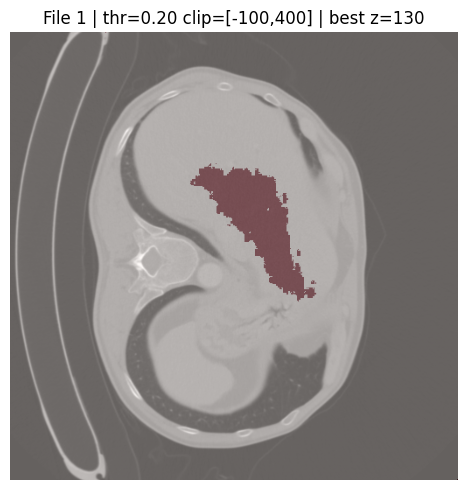

File 2: test-volume-1.nii | vox=249


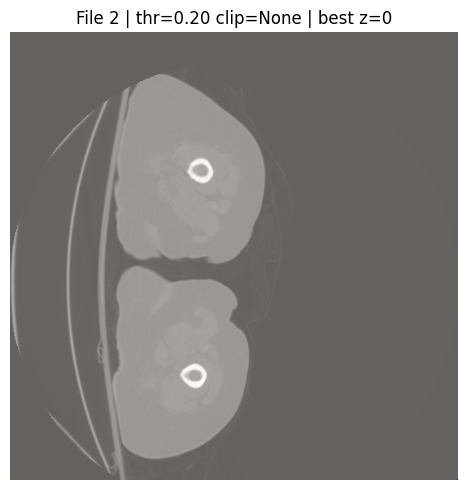

In [12]:
# Apply recommended parameters for files 1 and 2 (overlays)
import numpy as np, matplotlib.pyplot as plt, nibabel as nib, os
def overlay_best_slice(vol, mask, title):
    per_slice = mask.sum(axis=(0,1))
    if int(per_slice.sum()) == 0:
        print(title + ' | No voxels to show')
        return
    z_best = int(np.argmax(per_slice))
    img = vol[:, :, z_best]
    img_n = (img - img.min()) / (img.max() - img.min() + 1e-8)
    plt.figure(figsize=(6,5))
    plt.imshow(img_n, cmap='gray')
    plt.imshow(mask[:, :, z_best], cmap='Reds', alpha=0.4)
    plt.title(title + f' | best z={z_best}')
    plt.axis('off'); plt.tight_layout(); plt.show()

# File 1 (index 0)
if len(vol_paths) > 0 and liver_model is not None:
    vp0 = vol_paths[0]
    vol0 = nib.load(vp0).get_fdata().astype(np.float32)
    m0 = predict_mask_3d_with_clip(liver_model, vol0, device, threshold=0.20, clip=(-100, 400))
    print(f'File 1: {os.path.basename(vp0)} | vox={int(m0.sum())}')
    overlay_best_slice(vol0, m0, 'File 1 | thr=0.20 clip=[-100,400]')
else:
    print('File 1 unavailable or liver model not loaded.')

# File 2 (index 1)
if len(vol_paths) > 1 and liver_model is not None:
    vp1 = vol_paths[1]
    vol1 = nib.load(vp1).get_fdata().astype(np.float32)
    m1 = predict_mask_3d_with_clip(liver_model, vol1, device, threshold=0.20, clip=None)
    print(f'File 2: {os.path.basename(vp1)} | vox={int(m1.sum())}')
    overlay_best_slice(vol1, m1, 'File 2 | thr=0.20 clip=None')
else:
    print('File 2 unavailable or liver model not loaded.')

File 1 | thr=0.30 clip=(-100, 400) | vox=44364 | test-volume-0.nii


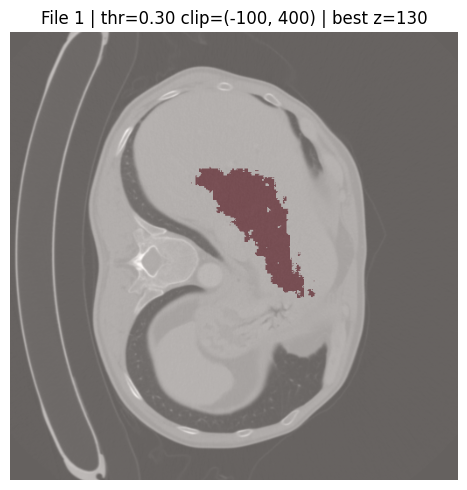

File 2 | thr=0.50 clip=None | vox=0 | test-volume-1.nii
File 2 | thr=0.50 clip=None | No voxels to show
File 3 | thr=0.30 clip=None | vox=1532 | test-volume-2.nii


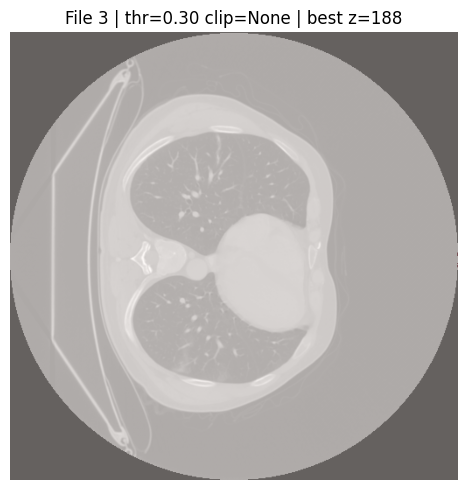

In [13]:
# Overlays for first three files (auto-pick params per file)
import numpy as np, matplotlib.pyplot as plt, nibabel as nib, os, glob
def pick_best_liver_mask(vol):
    base = predict_mask_3d(liver_model, vol, device, threshold=0.5)
    vox_base = int(base.sum())
    fb = predict_mask_3d_with_clip(liver_model, vol, device, threshold=0.3, clip=(-100, 400))
    vox_fb = int(fb.sum())
    if vox_fb > vox_base:
        return fb, 0.3, (-100, 400)
    if vox_base == 0:
        lo = predict_mask_3d_with_clip(liver_model, vol, device, threshold=0.3, clip=None)
        if int(lo.sum()) > 0:
            return lo, 0.3, None
    return base, 0.5, None
def overlay_best_slice_generic(vol, mask, title):
    per_slice = mask.sum(axis=(0,1))
    if int(per_slice.sum()) == 0:
        print(title + ' | No voxels to show')
        return
    z_best = int(np.argmax(per_slice))
    img = vol[:, :, z_best]
    img_n = (img - img.min()) / (img.max() - img.min() + 1e-8)
    plt.figure(figsize=(6,5))
    plt.imshow(img_n, cmap='gray')
    plt.imshow(mask[:, :, z_best], cmap='Reds', alpha=0.4)
    plt.title(title + f' | best z={z_best}')
    plt.axis('off'); plt.tight_layout(); plt.show()
in_dir = 'Test_Volume'
vol_paths = sorted(glob.glob(os.path.join(in_dir, '*.nii*')))
K = min(3, len(vol_paths))
for i in range(K):
    vp = vol_paths[i]
    vol = nib.load(vp).get_fdata().astype(np.float32)
    mask, thr, clip = pick_best_liver_mask(vol)
    ttl = f'File {i+1} | thr={thr:.2f} clip={clip}'
    print(f'{ttl} | vox={int(mask.sum())} | {os.path.basename(vp)}')
    overlay_best_slice_generic(vol, mask, ttl)